In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
        
#Scaling and Splitting
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split

#Modeling
from sklearn.linear_model import LassoLars
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

#Evaluation
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

/kaggle/input/trailer-prices/trailerdata1.csv
/kaggle/input/trailer-prices/trailerdata2.csv


# About this notebook
This notebook aims to predict the price of a product (trailer) for an early stage start-up. The data has been anonymized. Due to the web infrastructure of manufacturers of similar trailers, the data was collected by hand. This project is still on-going and updated regularly. 

## Current Challenges
Currently the challenge is to deal with the small amount of data. There are unfortunately not many data points available in general, but work is underway to fill in vital details to increase the dataset as much as possible. 

In [2]:
#The trailer price data is saved in a csv file and must first be loaded
data = pd.read_csv('/kaggle/input/trailer-prices/trailerdata1.csv', sep=';')
data.tail(15)

,total dry weight,length,exterior width,exterior height,interior height,A/C,Roof Rack,Driver Side Window,Driver Side Door,Driver Side Door Window,...,Passenger Side Door Window,Passenger Side Window,Rear Door,Rear Door Window,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,price
72,1350.0,165,80.0,68.75,44.5,Option,Yes,No,Yes,Yes,...,Yes,No,No,No,Option,Yes,Yes,Option,Yes,16250
73,1350.0,165,60.0,68.75,44.5,Option,Yes,No,Yes,Yes,...,Yes,No,No,No,Option,Yes,Yes,Option,Yes,17250
74,1750.0,200,80.0,69.00,44.5,Option,Yes,No,Yes,Yes,...,Yes,No,No,No,Option,Yes,Yes,Option,Yes,19950
75,2200.0,110,60.0,48.00,45.0,Yes,Yes,No,Yes,Yes,...,Yes,No,No,No,Yes,Yes,Yes,No,Yes,38990
76,3750.0,156,86.0,63.75,78.0,Yes,No,Yes,No,No,...,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,79990
77,640.0,140,76.0,62.00,38.0,No,No,Yes,Yes,Yes,...,Yes,Yes,No,No,No,No,Yes,No,No,9950
78,1200.0,157,72.0,64.00,42.0,Yes,Option,No,Yes,Yes,...,Yes,No,No,No,No,Yes,Yes,No,No,30590
79,1025.0,149,83.0,72.00,45.0,Yes,Option,Yes,No,No,...,Yes,Yes,Yes,No,Yes,Yes,Yes,No,Option,13174
80,1115.0,165,83.0,72.00,45.0,Yes,Option,Yes,No,No,...,Yes,Yes,Yes,No,Yes,Yes,Yes,No,Option,14350
81,1450.0,165,92.0,95.00,66.0,Yes,Option,No,Yes,No,...,Yes,Yes,Yes,No,Yes,Yes,Yes,No,Option,20230


In [3]:
#inspect the data types of each column
#for modeling everything needs to be and int or float
data.dtypes

total dry weight              float64
length                          int64
exterior width                float64
exterior height               float64
interior height               float64
A/C                            object
Roof Rack                      object
Driver Side Window             object
Driver Side Door               object
Driver Side Door Window        object
Passenger Side Door            object
Passenger Side Door Window     object
Passenger Side Window          object
Rear Door                      object
Rear Door Window               object
Spare Tire                     object
Battery Power Supply           object
Cabinets                       object
Refrigerator                   object
Awning                         object
price                           int64
dtype: object

In [4]:
#checking for missing values
#missing values must be dealt with for ML modeling
data.isna().sum()

total dry weight              0
length                        0
exterior width                0
exterior height               0
interior height               0
A/C                           0
Roof Rack                     0
Driver Side Window            0
Driver Side Door              0
Driver Side Door Window       0
Passenger Side Door           0
Passenger Side Door Window    0
Passenger Side Window         0
Rear Door                     0
Rear Door Window              0
Spare Tire                    0
Battery Power Supply          0
Cabinets                      0
Refrigerator                  0
Awning                        0
price                         0
dtype: int64

In [5]:
#drop columns which contain many empty values that are unlikely to be helpful in calculations
#data.drop(['model', 'year', 'sleeps', 'aluminum siding (inch)', 'A/C', 'msrp'], axis=1)

In [6]:
#83 is the target but it will be removed later to prevent problems later
#data2=data.drop(data.index[[83]])

In [7]:
data

,total dry weight,length,exterior width,exterior height,interior height,A/C,Roof Rack,Driver Side Window,Driver Side Door,Driver Side Door Window,...,Passenger Side Door Window,Passenger Side Window,Rear Door,Rear Door Window,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,price
0,1660.0,198,102.0,84.0,54.0,Yes,Option,Yes,No,No,...,Yes,Yes,No,No,Yes,Yes,Yes,Yes,Option,14879
1,2260.0,194,102.0,108.0,74.0,Yes,Option,Yes,No,No,...,Yes,Yes,No,No,Yes,Yes,Yes,Yes,No,18489
2,1320.0,144,102.0,90.0,54.0,Yes,Option,Yes,No,No,...,Yes,Yes,No,No,Yes,Yes,Yes,Yes,Option,12500
3,1320.0,144,102.0,90.0,54.0,Yes,Option,Yes,No,No,...,Yes,Yes,No,No,Yes,Yes,Yes,Yes,Option,14997
4,1930.0,185,102.0,105.0,73.0,Yes,Option,Yes,No,No,...,Yes,Yes,No,No,Yes,Yes,Yes,Yes,Option,15965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,2475.0,216,102.0,102.0,83.0,Yes,Option,Yes,Yes,No,...,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Option,28056
83,1500.0,168,80.0,66.0,43.5,Option,Option,No,Yes,Yes,...,Yes,No,No,No,Yes,Yes,Yes,Option,Option,18849
84,1500.0,168,80.0,72.0,43.5,Option,Option,No,Yes,Yes,...,Yes,No,No,No,Yes,Yes,Yes,Option,Option,19899
85,1250.0,168,80.0,68.0,43.5,Option,Option,Yes,Yes,Yes,...,Yes,Yes,Yes,No,Option,Yes,Yes,Option,Option,15099


In [8]:
data.isna().sum()

total dry weight              0
length                        0
exterior width                0
exterior height               0
interior height               0
A/C                           0
Roof Rack                     0
Driver Side Window            0
Driver Side Door              0
Driver Side Door Window       0
Passenger Side Door           0
Passenger Side Door Window    0
Passenger Side Window         0
Rear Door                     0
Rear Door Window              0
Spare Tire                    0
Battery Power Supply          0
Cabinets                      0
Refrigerator                  0
Awning                        0
price                         0
dtype: int64

In [9]:
data.shape

(87, 21)

In [10]:
#these columns will be renamed to remove the space in the heading 
data = data.rename(columns={"exterior height": "eheight", "total dry weight": "tdweight", "interior height":"intheight", "exterior width":"ewidth"})

In [11]:
#data2['intheight'] = data2['intheight'].fillna(data2['intheight'].mean())
#data2['ewidth'] = data2['ewidth'].fillna(data2['ewidth'].mean())

In [12]:
data.isna().sum()

tdweight                      0
length                        0
ewidth                        0
eheight                       0
intheight                     0
A/C                           0
Roof Rack                     0
Driver Side Window            0
Driver Side Door              0
Driver Side Door Window       0
Passenger Side Door           0
Passenger Side Door Window    0
Passenger Side Window         0
Rear Door                     0
Rear Door Window              0
Spare Tire                    0
Battery Power Supply          0
Cabinets                      0
Refrigerator                  0
Awning                        0
price                         0
dtype: int64

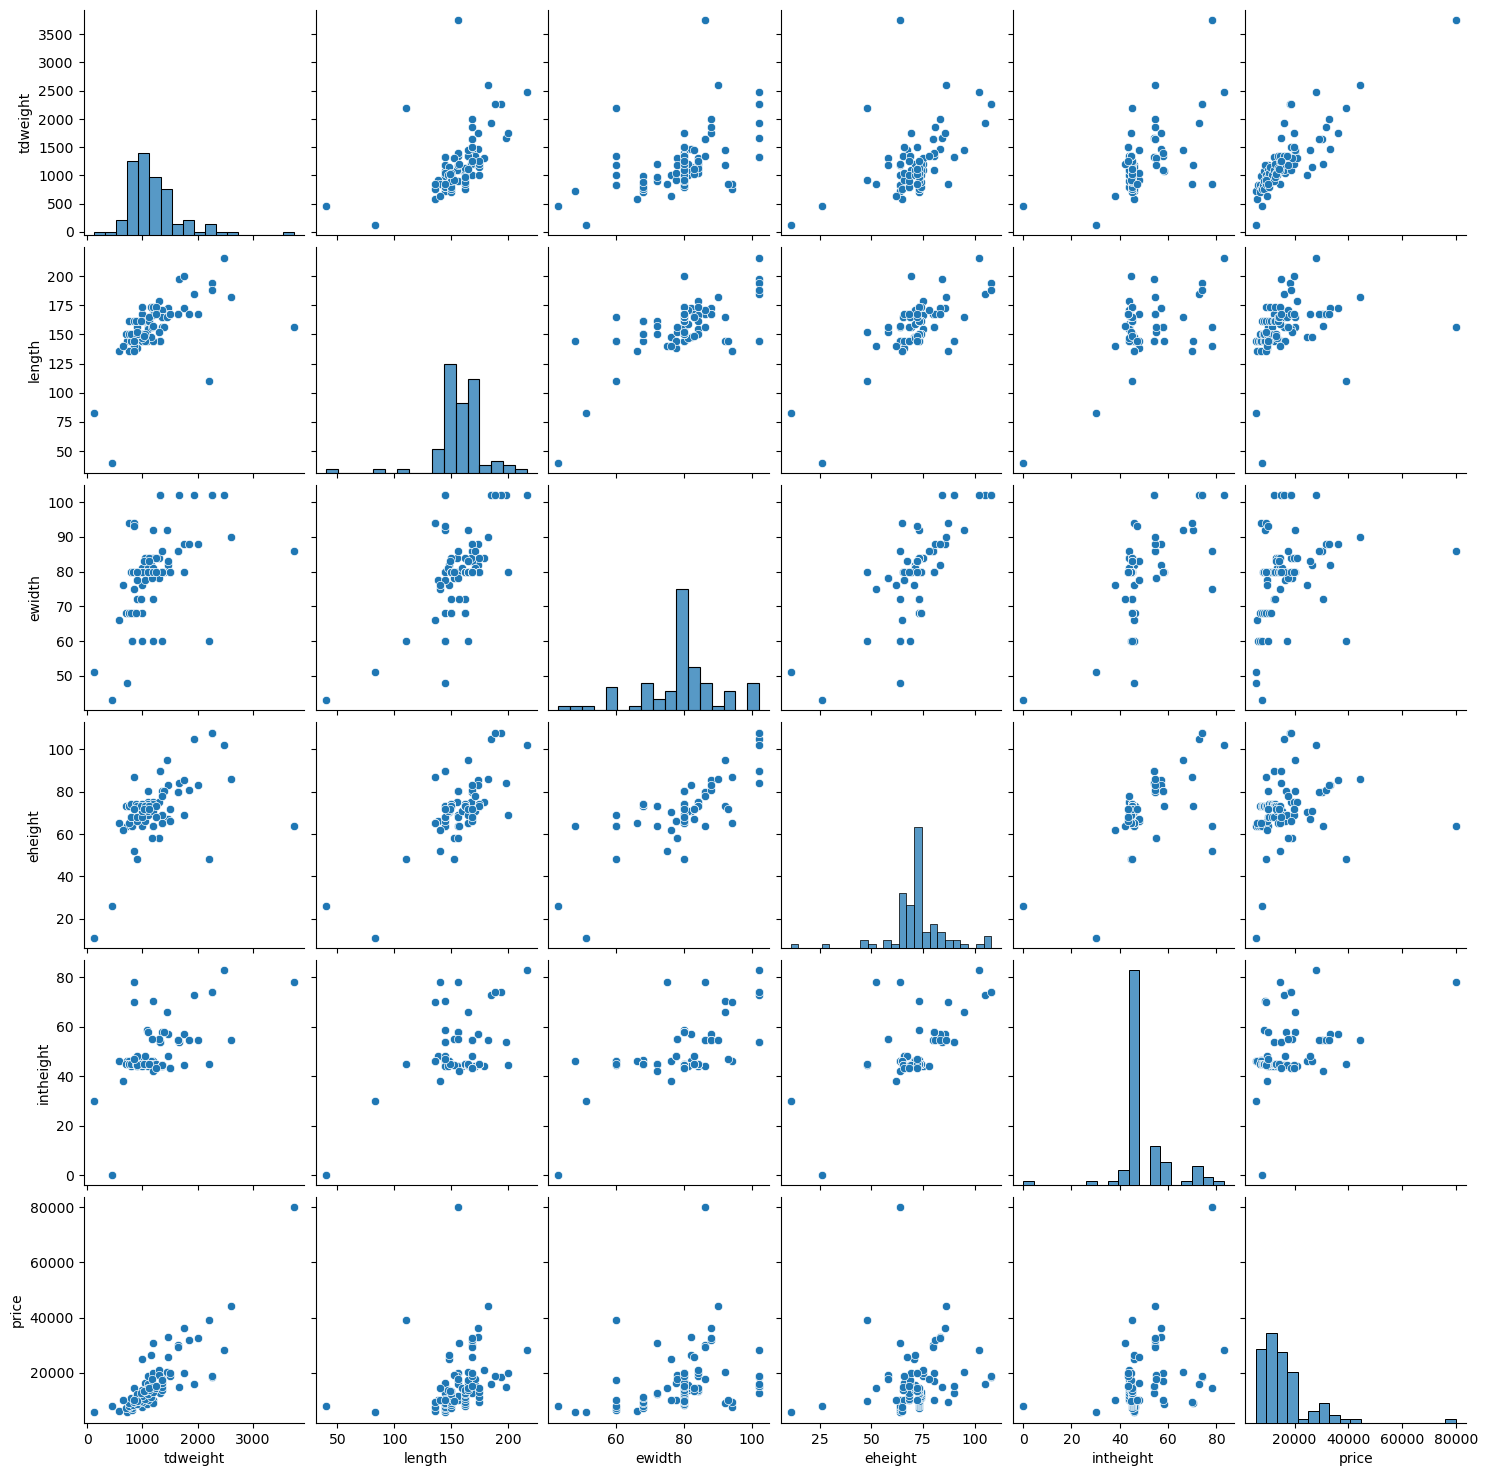

In [13]:
sns.pairplot(data)

Of all the variables, total dry weight appears to be the most correlated with the price. Let's look at it a bit more closely. 

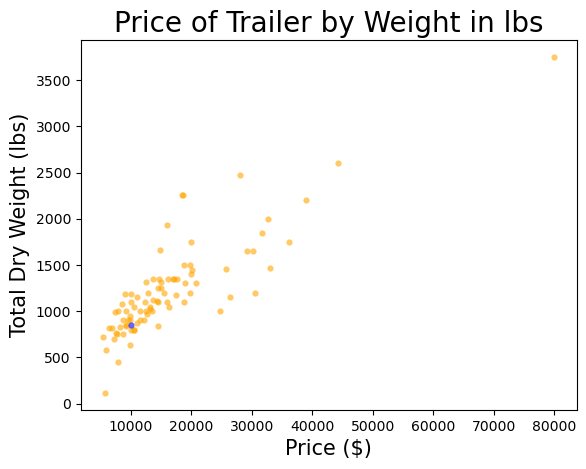

In [14]:
# values of x
x=data['price']
y= data['tdweight']

col = []
  
for i in range(0, len(x)):
    if x[i]==9995:
        col.append('blue')  
    else:
        col.append('orange') 
  
for i in range(len(x)):
      
    # plotting the corresponding x with y 
    # and respective color
    plt.scatter(x[i], y[i], c = col[i], s = 20,
                linewidth = 0, alpha=0.6)
    plt.title("Price of Trailer by Weight in lbs", fontsize=20)
    plt.ylabel("Total Dry Weight (lbs)", fontsize=15)
    plt.xlabel("Price ($)", fontsize=15)
      
plt.show()

In [15]:
#select the categorical data for encoding
cat_data = data.iloc[:, 5:20]
cat_data

,A/C,Roof Rack,Driver Side Window,Driver Side Door,Driver Side Door Window,Passenger Side Door,Passenger Side Door Window,Passenger Side Window,Rear Door,Rear Door Window,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning
0,Yes,Option,Yes,No,No,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,Option
1,Yes,Option,Yes,No,No,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,No
2,Yes,Option,Yes,No,No,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,Option
3,Yes,Option,Yes,No,No,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,Option
4,Yes,Option,Yes,No,No,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,Option
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,Yes,Option,Yes,Yes,No,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Option
83,Option,Option,No,Yes,Yes,Yes,Yes,No,No,No,Yes,Yes,Yes,Option,Option
84,Option,Option,No,Yes,Yes,Yes,Yes,No,No,No,Yes,Yes,Yes,Option,Option
85,Option,Option,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Option,Yes,Yes,Option,Option


In [16]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()

#label encode the data to prepare for modeling
#label encoding is preferred for categorical variables

for col in cat_data:
    data[col] = labelencoder.fit_transform(data[col])
 
data.head()

,tdweight,length,ewidth,eheight,intheight,A/C,Roof Rack,Driver Side Window,Driver Side Door,Driver Side Door Window,...,Passenger Side Door Window,Passenger Side Window,Rear Door,Rear Door Window,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,price
0,1660.0,198,102.0,84.0,54.0,2,1,2,0,0,...,2,1,0,0,2,2,1,2,1,14879
1,2260.0,194,102.0,108.0,74.0,2,2,2,0,0,...,2,1,0,0,2,2,1,2,0,18489
2,1320.0,144,102.0,90.0,54.0,2,2,2,0,0,...,2,1,0,0,2,2,1,2,1,12500
3,1320.0,144,102.0,90.0,54.0,2,2,2,0,0,...,2,1,0,0,2,2,1,2,1,14997
4,1930.0,185,102.0,105.0,73.0,2,2,2,0,0,...,2,1,0,0,2,2,1,2,1,15965


In [17]:
#make a copy of the data for later
data2=data

In [18]:
corr=data2.corr()
corr

,tdweight,length,ewidth,eheight,intheight,A/C,Roof Rack,Driver Side Window,Driver Side Door,Driver Side Door Window,...,Passenger Side Door Window,Passenger Side Window,Rear Door,Rear Door Window,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,price
tdweight,1.000000,0.534052,0.513202,0.482103,0.603769,0.449094,-0.098091,0.151367,-0.080997,-0.042213,...,0.222060,0.145630,0.222118,0.324009,0.462419,0.518905,0.523712,0.585371,0.155867,0.845581
length,0.534052,1.000000,0.602215,0.722761,0.519619,0.197489,0.156994,0.144524,0.200738,0.201226,...,0.438394,0.189892,0.133314,-0.046230,0.318759,0.382198,0.368459,0.423404,0.238815,0.271262
ewidth,0.513202,0.602215,1.000000,0.734740,0.618870,0.414561,0.059663,0.180550,-0.149084,-0.109380,...,0.340233,0.304025,0.285292,0.131432,0.535200,0.409106,0.342770,0.456762,0.130390,0.285521
eheight,0.482103,0.722761,0.734740,1.000000,0.643435,0.382342,0.095424,0.319367,-0.075828,-0.104329,...,0.406862,0.382391,0.152507,-0.047391,0.370642,0.314757,0.279247,0.407020,-0.017153,0.178398
intheight,0.603769,0.519619,0.618870,0.643435,1.000000,0.471729,-0.017975,0.276814,-0.243285,-0.298679,...,0.144267,0.276157,0.144481,0.185680,0.264472,0.103927,0.214647,0.342717,-0.141213,0.388040
A/C,0.449094,0.197489,0.414561,0.382342,0.471729,1.000000,-0.211362,0.455863,-0.411530,-0.338195,...,0.227326,0.411305,-0.050808,0.180533,0.210322,0.192138,0.415918,0.415850,-0.204208,0.248638
Roof Rack,-0.098091,0.156994,0.059663,0.095424,-0.017975,-0.211362,1.000000,-0.315956,0.192285,0.102315,...,-0.137374,-0.147425,0.109745,-0.039923,-0.020771,0.150379,-0.351526,-0.201675,0.408661,-0.256828
Driver Side Window,0.151367,0.144524,0.180550,0.319367,0.276814,0.455863,-0.315956,1.000000,-0.191633,-0.187730,...,0.179828,0.819454,-0.027706,-0.044300,0.027327,-0.069492,0.126736,0.386668,-0.348870,-0.005805
Driver Side Door,-0.080997,0.200738,-0.149084,-0.075828,-0.243285,-0.411530,0.192285,-0.191633,1.000000,0.722511,...,0.106792,-0.135693,0.168879,-0.276307,-0.159079,-0.047057,-0.023795,-0.026783,0.298445,0.013541
Driver Side Door Window,-0.042213,0.201226,-0.109380,-0.104329,-0.298679,-0.338195,0.102315,-0.187730,0.722511,1.000000,...,0.459293,-0.106582,-0.006251,-0.051402,-0.079543,-0.007735,0.137640,0.103667,0.324327,0.099122


<AxesSubplot:>

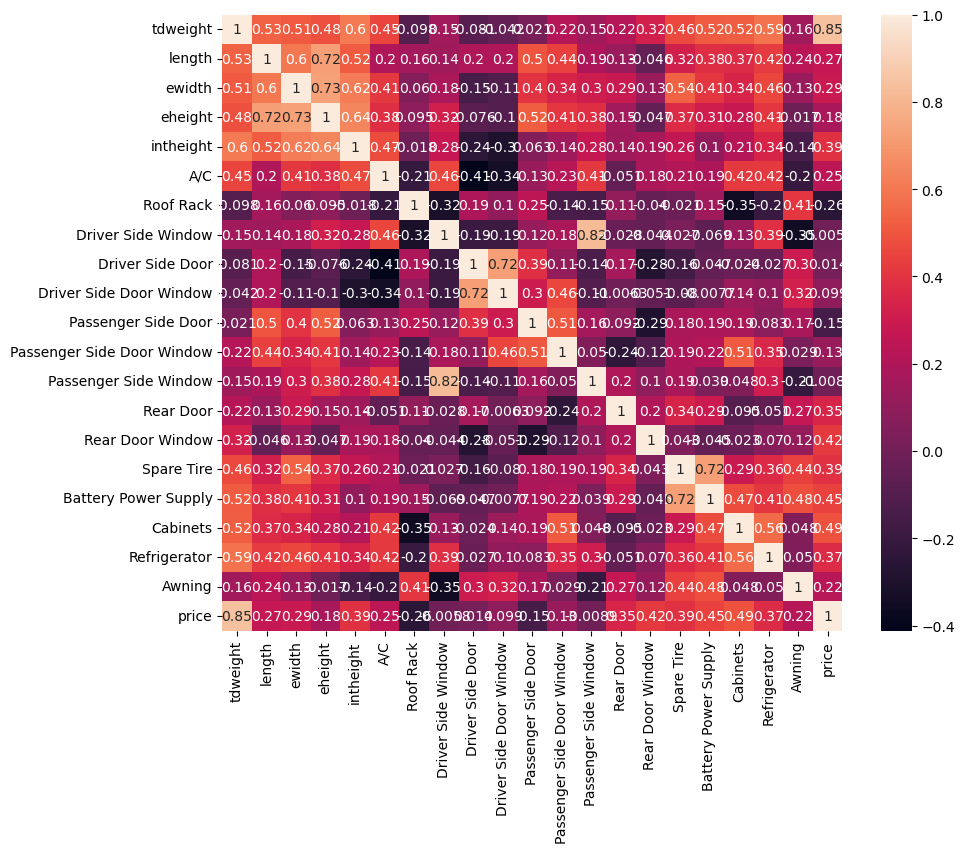

In [19]:
plt.figure(figsize=(10,8))
sns.heatmap(corr,annot=True)

# Machine Learning Modeling
The data is now clean and we can move forward with creating some machine learning models. Once we settle on the best model it can be used to predict the target price of the trailer in question.

#Replace "option" with "no" and try modeling again

In [20]:
data2=data2.drop(data.index[[86]])

In [21]:
#here the data is split up into X,y where X contains everything but price and y contains what we want to predict (price)
#price is what we want to predict
X = data2.drop(['price'],axis=1)
y=data2['price']

In [22]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [23]:
#scaling the data
#this usually helps with modeling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
#function which runs different ML models and prints R^2, MAE and RMSE
def run_experiment(model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))

Now the data is all cleaned up and ready for creating some machine learning models. A funtion has been written to run various models and output metrics 

In [25]:
model_1 = LinearRegression()
run_experiment(model_1)

R^2 :  0.6233797411983084
MAE : 2590.812373252396
RMSE: 3023.3524951619033


In [26]:
model_2 = DecisionTreeRegressor(random_state = 1)
run_experiment(model_2)

R^2 :  -0.265838757904596
MAE : 4099.090909090909
RMSE: 5542.760848005425


In [27]:
model_3 = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=1)
run_experiment(model_3)

R^2 :  0.36351470000969754
MAE : 3602.739354810096
RMSE: 3930.349174425099


In [28]:
model_4 = Lasso(alpha=0.1, precompute=True, positive=True, selection='random', random_state=1)
run_experiment(model_4)

R^2 :  0.5470782072863773
MAE : 2704.3201541113744
RMSE: 3315.496356302968


In [29]:
model_5 = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=1)
run_experiment(model_5)

R^2 :  0.5976334977215587
MAE : 2684.4408833755424
RMSE: 3124.9844097601476


In [30]:
model_6 = LassoLars(alpha=.1)
run_experiment(model_6)

R^2 :  0.6230237179234384
MAE : 2594.1659574920836
RMSE: 3024.7811617989887


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


In [31]:
model_7 = BayesianRidge()
run_experiment(model_7)

R^2 :  0.537035583296092
MAE : 2851.8645521989183
RMSE: 3352.052040597221


In [32]:
model_8 = SGDRegressor(max_iter=1000, tol=1e-3)
run_experiment(model_8)

R^2 :  0.5489262958325882
MAE : 2814.164129685843
RMSE: 3308.7252159329887


In [33]:
model_9 = SVR(epsilon=0.2)
run_experiment(model_9)

R^2 :  -0.018426738767175932
MAE : 3644.36051568069
RMSE: 4971.664832313496


In [34]:
model_10 = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, random_state=1)
run_experiment(model_10)

R^2 :  0.5497027683458955
MAE : 2597.784981421357
RMSE: 3305.8761906718964


Unsurprisingly, RandomForest preformed better than all the other models tested. Therefore we will move forward with tuning hyperparameters to figure out which produce the best result.

# Checking Feature Importance

In [35]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = data2.drop(['price'],axis=1)
y=data2['price']
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the columns
print(featureScores.nlargest(20,'Score'))  #print 10 best features

                         Specs         Score
0                     tdweight  18441.699246
1                       length    265.877680
3                      eheight    222.637892
4                    intheight    213.598405
2                       ewidth    145.052624
13                   Rear Door    102.625000
14            Rear Door Window     85.000000
18                Refrigerator     74.263158
7           Driver Side Window     58.675676
5                          A/C     58.310345
9      Driver Side Door Window     56.544643
16        Battery Power Supply     44.888889
6                    Roof Rack     44.355705
8             Driver Side Door     38.696970
17                    Cabinets     36.000000
11  Passenger Side Door Window     32.802920
19                      Awning     29.853933
15                  Spare Tire     29.318584
12       Passenger Side Window     25.283333
10         Passenger Side Door      5.000000


[0.18836938 0.15644491 0.11327126 0.11073772 0.05488052 0.03295889
 0.05232105 0.02159802 0.0219006  0.02398362 0.00874072 0.02273647
 0.01831498 0.02592703 0.00246988 0.02803724 0.02846482 0.03007047
 0.02762561 0.03114681]


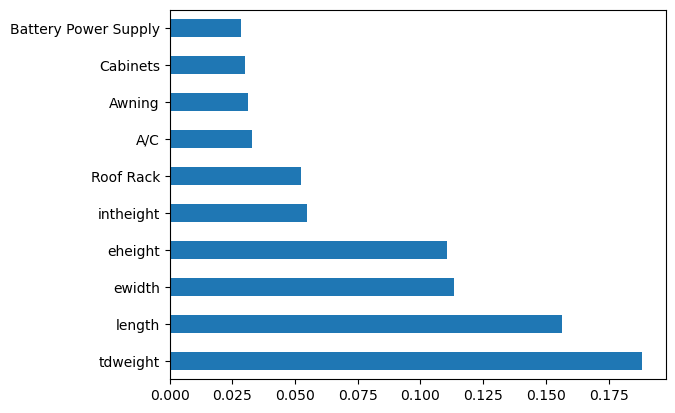

In [36]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

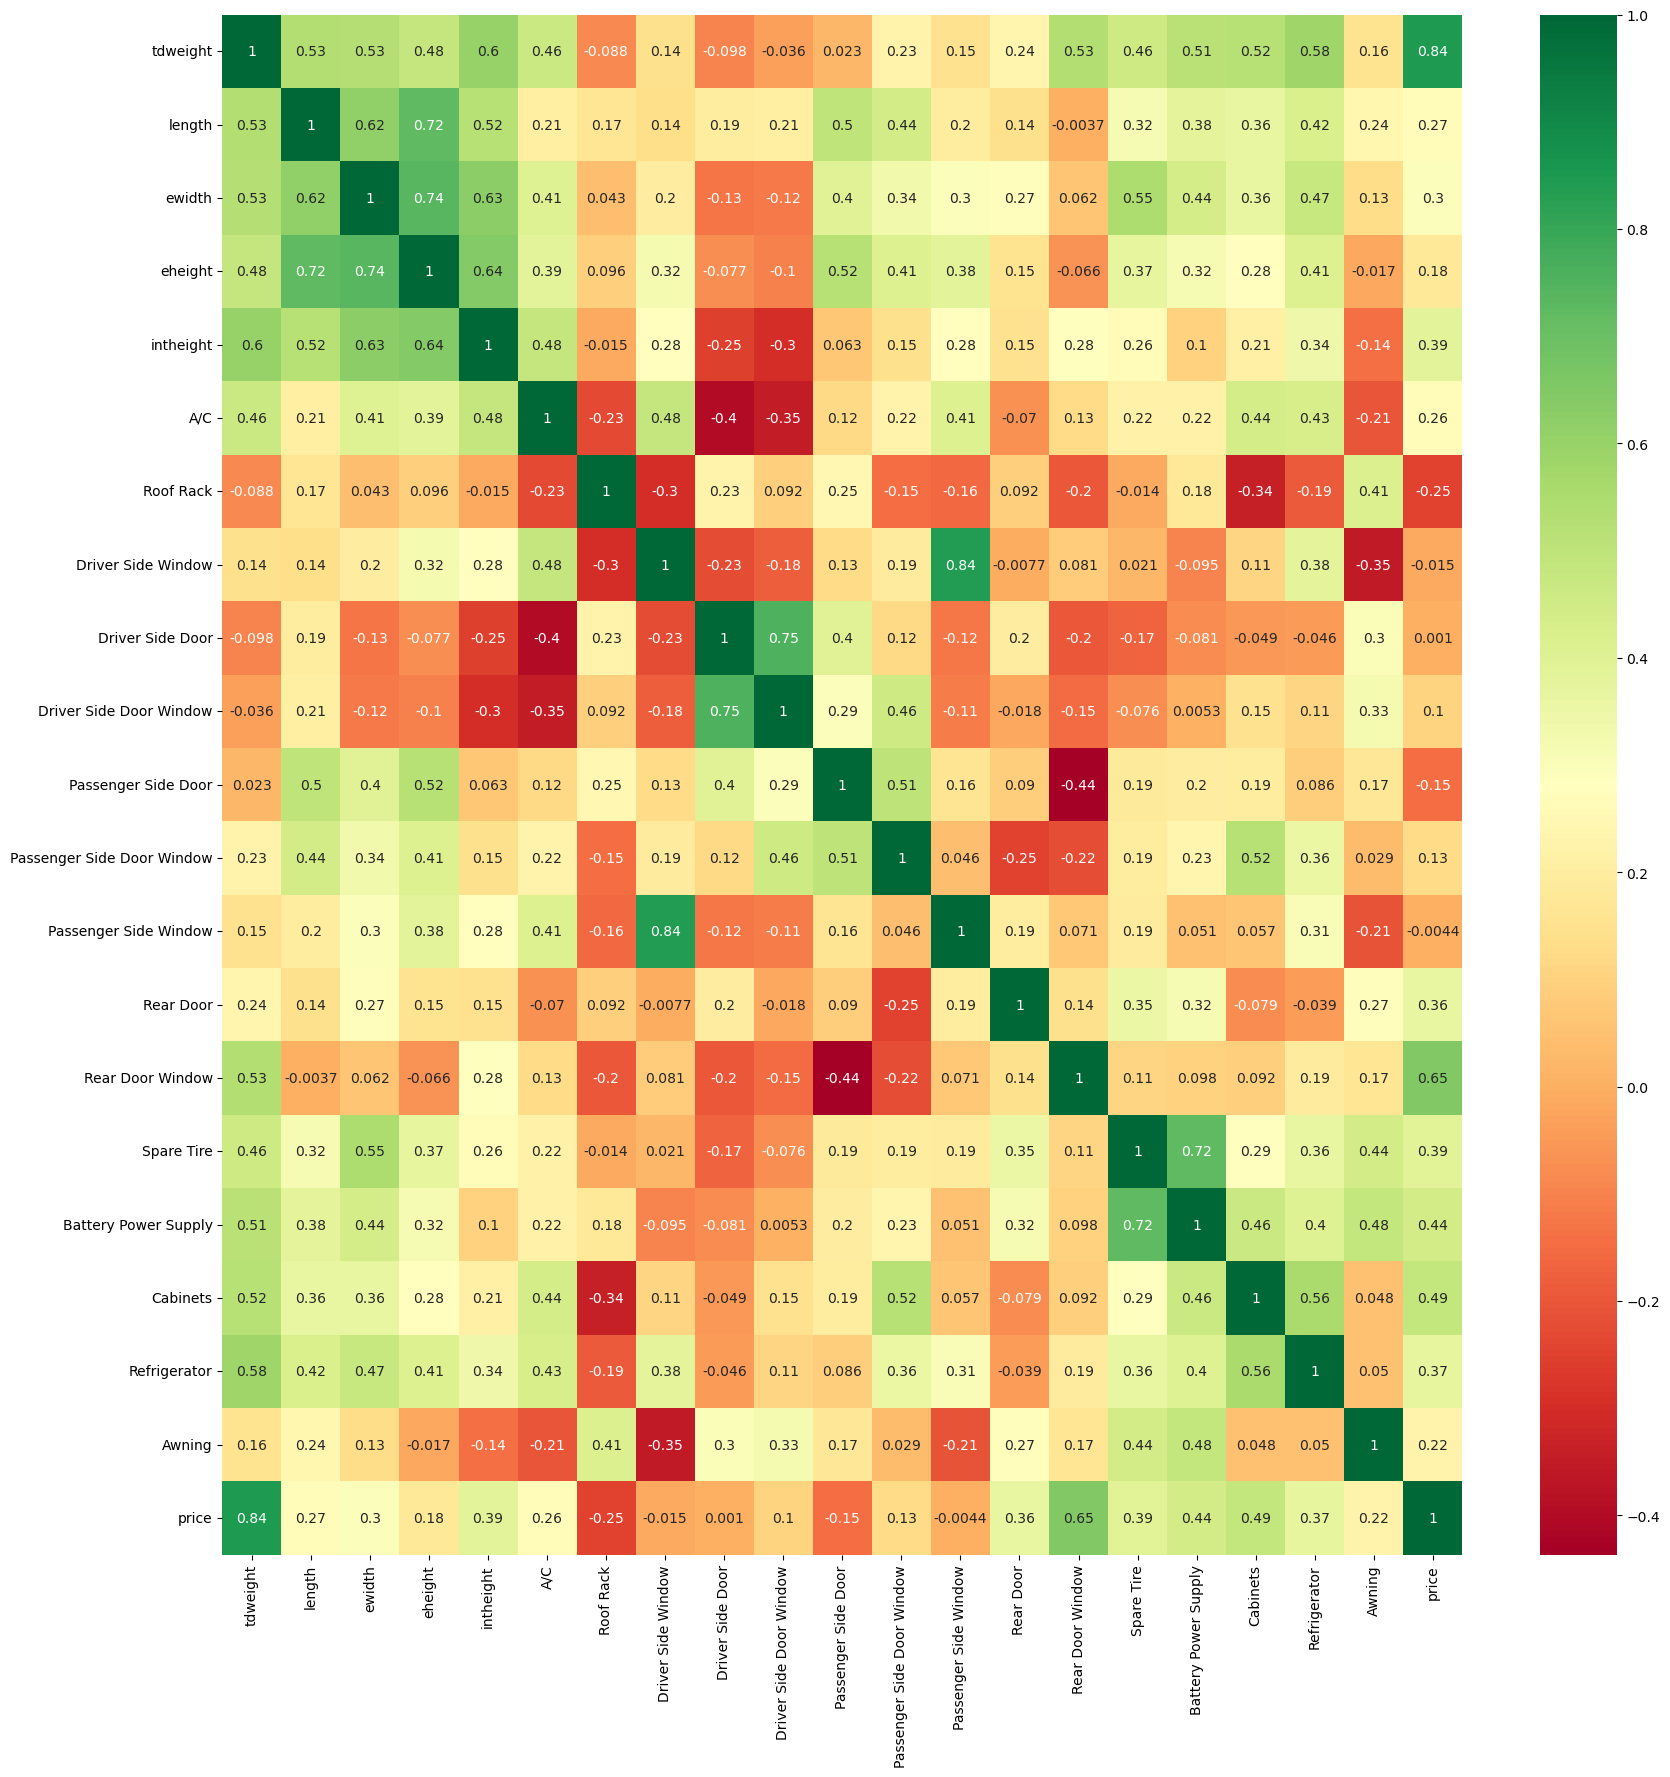

In [37]:
#get correlations of each features in dataset
corrmat = data2.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data2[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# Feature Engineering
This section is in progress while more feature data is collected.

In [38]:
data3=data.drop(data.index[[86]])

In [39]:
#removing everything with a negative correlation
X = data3.drop(['price', 'Roof Rack', 'Driver Side Window', 'Driver Side Door', 'Passenger Side Door', 'Passenger Side Window'],axis=1)
y=data3['price']

In [40]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [41]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [42]:
def run_experiment(model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))

In [43]:
model_1 = LinearRegression()
run_experiment(model_1)

R^2 :  0.5939793483310953
MAE : 2760.8414572488236
RMSE: 3139.142336286344


In [44]:
model_2 = DecisionTreeRegressor(random_state = 1)
run_experiment(model_2)

R^2 :  -0.15899762155032637
MAE : 3602.681818181818
RMSE: 5303.691060349986


In [45]:
model_3 = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=1)
run_experiment(model_3)

R^2 :  0.34087647783669683
MAE : 3468.40328772526
RMSE: 3999.6349198655707


In [46]:
model_4 = Lasso(alpha=0.1, precompute=True, positive=True, selection='random', random_state=1)
run_experiment(model_4)

R^2 :  0.5470666434990477
MAE : 2704.325919736362
RMSE: 3315.538680883788


In [47]:
model_5 = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=1)
run_experiment(model_5)

R^2 :  0.5916152639511159
MAE : 2736.5441958845313
RMSE: 3148.2680125977


In [48]:
model_7 = BayesianRidge()
run_experiment(model_7)

R^2 :  0.5827763254028046
MAE : 2680.217944277373
RMSE: 3182.155645284396


In [49]:
model_8 = SGDRegressor(max_iter=1000, tol=1e-3)
run_experiment(model_8)

R^2 :  0.5710696557243071
MAE : 2779.6710682771886
RMSE: 3226.4900614506787


In [50]:
model_9 = SVR(epsilon=0.2)
run_experiment(model_9)

R^2 :  -0.018020316543204684
MAE : 3643.9249309473903
RMSE: 4970.672715438341


In [51]:
model_10 = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, random_state=1)
run_experiment(model_10)

R^2 :  0.6146471199299706
MAE : 2270.8579542515567
RMSE: 3058.202582699763


[0.20380758 0.16035814 0.12635001 0.12721704 0.07235245 0.03787846
 0.03736914 0.02730793 0.03483474 0.00370528 0.03145598 0.03261745
 0.03159315 0.03267513 0.04047751]


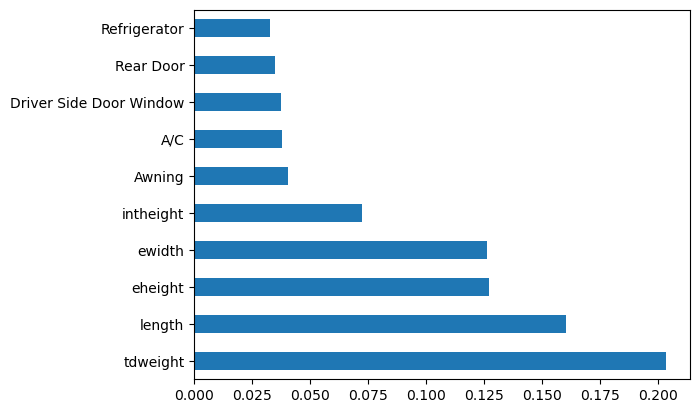

In [52]:
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

## Hyperparameter Tuning
Perhaps it is a bit early to get into hyperparameter tuning, but nonetheless the code is ready for once the dataset has been expanded :) Commented out for time saving purposes.

In [53]:
rfc=RandomForestRegressor(random_state=1)

In [54]:
param_grid = { 
    'n_estimators': [100, 500, 1000, 5000],
    'max_features': ['auto', 'sqrt', 'log2'],
    #to save time in updating the notebook, max_depth is also left out
     #'max_depth' : [5, 10, 15],
     #'min_samples_leaf' : [1,2,3,5],
     #'criterion' :['squared_error', 'absolute_error', 'friedman_mse']
}


In [55]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
CV_rfc.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=1),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 500, 1000, 5000]})

In [56]:
#print the best parameters determined in GridSearchCV
CV_rfc.best_params_

{'max_features': 'auto', 'n_estimators': 100}

In [57]:
#run a final model using the optimal parameters
final_model = RandomForestRegressor(criterion= 'squared_error', n_estimators=5000, max_features='auto', max_depth=15, min_samples_leaf=1, random_state=1)
run_experiment(final_model)

R^2 :  0.5619213264866644
MAE : 2440.9920077922075
RMSE: 3260.7162052997705


# Checking the value of interest

In [58]:
new_input = data.loc[86:87]
new_input

,tdweight,length,ewidth,eheight,intheight,A/C,Roof Rack,Driver Side Window,Driver Side Door,Driver Side Door Window,...,Passenger Side Door Window,Passenger Side Window,Rear Door,Rear Door Window,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,price
86,850.0,144,93.0,72.0,47.0,2,3,0,0,2,...,2,1,2,1,1,0,0,0,1,9995


In [59]:
#drop the variable to be predicted
new_input=new_input.drop(['price', 'Roof Rack', 'Driver Side Window', 'Driver Side Door', 'Passenger Side Door', 'Passenger Side Window'],axis=1)
new_input

,tdweight,length,ewidth,eheight,intheight,A/C,Driver Side Door Window,Passenger Side Door Window,Rear Door,Rear Door Window,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning
86,850.0,144,93.0,72.0,47.0,2,2,2,2,1,1,0,0,0,1


In [60]:
new_input_scaled = scaler.fit_transform(new_input)

In [61]:
new_output = model_1.predict(new_input_scaled)
new_output

array([16941.625])

# Notes on the metrics used
✔️ Regression Evaluation Metrics
Here are three common evaluation metrics for regression problems:

Mean Absolute Error (MAE) is the mean of the absolute value of the errors:
1𝑛∑𝑖=1𝑛|𝑦𝑖−𝑦̂𝑖|
1
n
∑
i
=
1
n
|
y
i
−
y
^
i
|
 

 
Mean Squared Error (MSE) is the mean of the squared errors:
1𝑛∑𝑖=1𝑛(𝑦𝑖−𝑦̂𝑖)2
1
n
∑
i
=
1
n
(
y
i
−
y
^
i
)
2
 
Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors:
1𝑛∑𝑖=1𝑛(𝑦𝑖−𝑦̂𝑖)2‾‾‾‾‾‾‾‾‾‾‾‾‾‾⎷
1
n
∑
i
=
1
n
(
y
i
−
y
^
i
)
2
 
📌 Comparing these metrics:

MAE is the easiest to understand, because it's the average error.
MSE is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units.
All of these are loss functions, because we want to minimize them.

https://www.kaggle.com/code/faressayah/practical-introduction-to-10-regression-algorithm?scriptVersionId=117768677&cellId=36

<iframe src="https://www.kaggle.com/embed/faressayah/practical-introduction-to-10-regression-algorithm?cellIds=36&kernelSessionId=117768677" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="Practical Introduction to 10 Regression Algorithm"></iframe>